In [1]:
# import คำสั่งที่จำเป็นต้องใช้

import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

In [2]:
img_paths = pd.read_csv('img_path.csv')
img_paths.head()

,img_path,label
0,original_images\0\o1.jpg,0
1,original_images\0\o10.jpg,0
2,original_images\0\o100.jpg,0
3,original_images\0\o1000.jpg,0
4,original_images\0\o1001.jpg,0


In [3]:
import os
PATH = 'original_images'

classes_wo_digits = os.listdir(PATH)

classes_wo_digits.sort()

classes_wo_digits = classes_wo_digits[1:]

print(classes_wo_digits)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
label = classes_wo_digits

In [5]:
len(label)

10

In [6]:
num_classes = len(label)

In [7]:
import tensorflow.keras as keras
import random
datagen = keras.preprocessing.image.ImageDataGenerator(
                                            rescale = 1./255,
                                            rotation_range = 45,
                                            width_shift_range = 0.1,  # randomly shift images horizontally 10%
                                            height_shift_range=0.1,  # randomly shift images vertically 10%
                                            validation_split=0.2
                                            )

train_generator = datagen.flow_from_directory(
                                        'original_images',
                                        target_size=(224, 224),
                                        seed=123,
                                        subset='training',
                                        batch_size=32,
                                        classes=classes_wo_digits
                                              )

validation_generator = datagen.flow_from_directory(
                                        'original_images',
                                        target_size=(224, 224), 
                                        seed=123,
                                        batch_size=32,
                                        subset='validation', 
                                        shuffle=False, 
                                        classes=classes_wo_digits)


Found 200 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


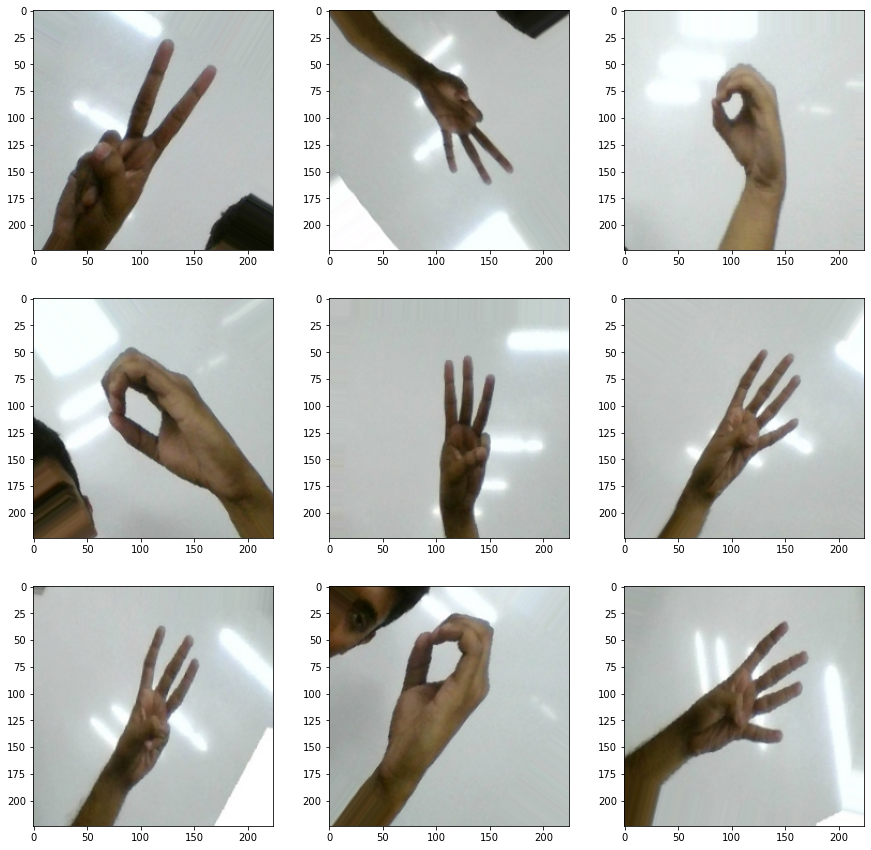

In [8]:
plt.figure(figsize=(15,15))
for i in range(9):
    
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
    
plt.show()

In [9]:
# import คำสั่งของ VGG16
from keras.applications.vgg16 import VGG16

# กำหนดขนาดรูปภาพ และจำนวนของ class label
im_shape = (224,224)
num_classes = 10

model_vgg16 = Sequential()

# โหลด pre-trained แต่ include_top = False เพราะเราต้องการมาปรับส่วน Classification เอง
pretrained_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

# False เพราะไม่ต้องการเปลี่ยน weight ใน pre-trained
for layer in pretrained_vgg16.layers:
    layer.trainable=False

# นำส่วนของ pretrain มาทำต่อ
model_vgg16.add(pretrained_vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(1024, activation = 'relu'))
model_vgg16.add(Dense(256, activation = 'relu'))

# แก้ในส่วนของ output node
model_vgg16.add(Dense(num_classes, activation='softmax'))

# ใช้ optimizer ของ Adam, learning rate = 0.001
model_vgg16.compile(optimizer= tf.keras.optimizers.Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 40,670,794
Trainable params: 25,956,106
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
# fit model, batch size = 32, epochs = 50

history_vgg16 = model_vgg16.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data = validation_generator,
          validation_steps = len(validation_generator),
          batch_size = 32,
          verbose = 1,
          epochs=50)

Epoch 1/50
7/7 [==============================] - 19s 3s/step - loss: 7.8073 - accuracy: 0.1550 - val_loss: 7.1820 - val_accuracy: 0.1200
Epoch 2/50
7/7 [==============================] - 19s 3s/step - loss: 5.1841 - accuracy: 0.1600 - val_loss: 2.4018 - val_accuracy: 0.2200
Epoch 3/50
7/7 [==============================] - 18s 3s/step - loss: 2.3211 - accuracy: 0.2450 - val_loss: 1.8388 - val_accuracy: 0.3400
Epoch 4/50
7/7 [==============================] - 17s 3s/step - loss: 1.7688 - accuracy: 0.4000 - val_loss: 1.6318 - val_accuracy: 0.5200
Epoch 5/50
7/7 [==============================] - 18s 3s/step - loss: 1.5522 - accuracy: 0.4750 - val_loss: 1.6517 - val_accuracy: 0.3400
Epoch 6/50
7/7 [==============================] - 18s 3s/step - loss: 1.3081 - accuracy: 0.5650 - val_loss: 1.4100 - val_accuracy: 0.4600
Epoch 7/50
7/7 [==============================] - 18s 3s/step - loss: 1.0510 - accuracy: 0.6050 - val_loss: 1.1677 - val_accuracy: 0.6000
Epoch 8/50
7/7 [==================

In [11]:
# Evaluate model's accuracy
# ประเมินความถูกต้องของ model โดยประเมินจากข้อมูล validation

score = model_vgg16.evaluate(validation_generator)
print("Loss is", score[0])
print("Accuracy score is", score[1])

2/2 [==============================] - 4s 1s/step - loss: 0.4925 - accuracy: 0.8800
Loss is 0.4925324320793152
Accuracy score is 0.8799999952316284


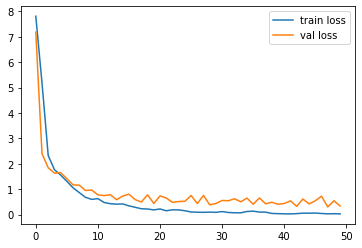

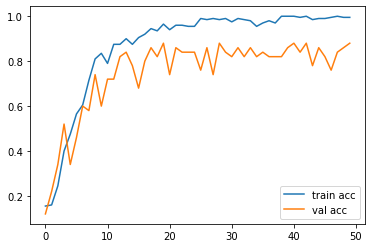

In [12]:
# plot the loss
# plot กราฟของค่า loss

plt.plot(history_vgg16.history['loss'], label='train loss')
plt.plot(history_vgg16.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
# plot กราฟของค่า accuracy
plt.plot(history_vgg16.history['accuracy'], label='train acc')
plt.plot(history_vgg16.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [13]:
# import คำสั่งของ MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# กำหนดขนาดรูปภาพ และจำนวนของ class label
im_shape = (224,224)
num_classes = 10

model_mobilenetv2 = Sequential()

# โหลด pre-trained แต่ include_top = False เพราะเราต้องการมาปรับส่วน Classification เอง
pretrained_mobilenet2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

# False เพราะไม่ต้องการเปลี่ยน weight ใน pre-trained
for layer in pretrained_mobilenet2.layers:
    layer.trainable=False

# นำส่วนของ pretrain มาทำต่อ
model_mobilenetv2.add(pretrained_mobilenet2)
model_mobilenetv2.add(GlobalAveragePooling2D())
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(512, activation = 'relu'))
model_mobilenetv2.add(Dense(256, activation = 'relu'))

# แก้ในส่วนของ output node
model_mobilenetv2.add(Dense(num_classes, activation='softmax'))

# ใช้ optimizer ของ Adam, learning rate = 0.0001
model_mobilenetv2.compile(optimizer= tf.keras.optimizers.Adam(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_mobilenetv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 3,047,754
Trainable params: 789,770
Non-trainable params: 2,257,984
______________________________________

In [14]:
# fit model, batch size = 32, epochs = 50
history_mobilenetv2 = model_mobilenetv2.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data = validation_generator,
          validation_steps = len(validation_generator),
          batch_size = 32,
          verbose = 1,
          epochs=50)

Epoch 1/50
7/7 [==============================] - 9s 975ms/step - loss: 2.5026 - accuracy: 0.1350 - val_loss: 2.3290 - val_accuracy: 0.1400
Epoch 2/50
7/7 [==============================] - 6s 889ms/step - loss: 2.2738 - accuracy: 0.1450 - val_loss: 2.1308 - val_accuracy: 0.3200
Epoch 3/50
7/7 [==============================] - 6s 884ms/step - loss: 2.0352 - accuracy: 0.4100 - val_loss: 1.9574 - val_accuracy: 0.5600
Epoch 4/50
7/7 [==============================] - 6s 843ms/step - loss: 1.8914 - accuracy: 0.4900 - val_loss: 1.9122 - val_accuracy: 0.4400
Epoch 5/50
7/7 [==============================] - 6s 920ms/step - loss: 1.7254 - accuracy: 0.5350 - val_loss: 1.7124 - val_accuracy: 0.5800
Epoch 6/50
7/7 [==============================] - 7s 950ms/step - loss: 1.6043 - accuracy: 0.5550 - val_loss: 1.6152 - val_accuracy: 0.5200
Epoch 7/50
7/7 [==============================] - 6s 879ms/step - loss: 1.4855 - accuracy: 0.6250 - val_loss: 1.4839 - val_accuracy: 0.6400
Epoch 8/50
7/7 [====

In [15]:
# Evaluate model's accuracy
# ประเมินความถูกของโมเดล โดยใช้ข้อมูล validation
score = model_mobilenetv2.evaluate(validation_generator)
print("Loss is", score[0])
print("Accuracy score is", score[1])

2/2 [==============================] - 1s 321ms/step - loss: 0.3541 - accuracy: 0.9200
Loss is 0.3541361093521118
Accuracy score is 0.9200000166893005


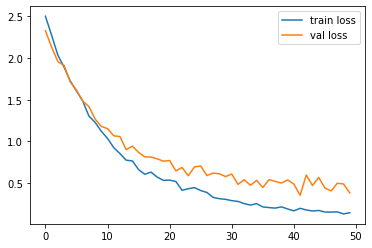

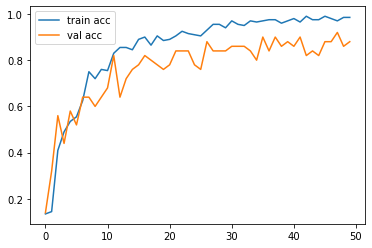

In [16]:
# plot the loss
# plot กราฟของค่า loss
plt.plot(history_mobilenetv2.history['loss'], label='train loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
# plot กราฟของค่า accuracy
plt.plot(history_mobilenetv2.history['accuracy'], label='train acc')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
# import คำสั่งของ DenseNet169
from tensorflow.keras.applications.densenet import DenseNet169

# กำหนดขนาดรูปภาพ และจำนวนของ class label
im_shape = (224,224)
num_classes = 10

model_densenet169 = Sequential()

# โหลด pre-trained แต่ include_top = False เพราะเราต้องการมาปรับส่วน Classification เอง
pretrained_densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

# False เพราะไม่ต้องการเปลี่ยน weight ใน pre-trained
for layer in pretrained_densenet169.layers:
    layer.trainable=False

# นำส่วนของ pretrain มาทำต่อ
model_densenet169.add(pretrained_densenet169)
model_densenet169.add(Flatten())
model_densenet169.add(BatchNormalization())
model_densenet169.add(Dense(256, kernel_initializer='he_uniform'))
model_densenet169.add(BatchNormalization())
model_densenet169.add(Activation('relu'))

# แก้ในส่วนของ output node
model_densenet169.add(Dense(num_classes, activation='softmax'))

# ใช้ optimizer ของ Adam, learning rate = 0.001
model_densenet169.compile(optimizer= tf.keras.optimizers.Adam(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_densenet169.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten_2 (Flatten)          (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               20873472  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [18]:
# fit model, batch size = 32, epochs = 50
history_densenet169 = model_densenet169.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data = validation_generator,
          validation_steps = len(validation_generator),
          batch_size = 32,
          epochs=50)

Epoch 1/50
7/7 [==============================] - 21s 2s/step - loss: 2.2261 - accuracy: 0.3150 - val_loss: 4.8009 - val_accuracy: 0.3400
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 1.1557 - accuracy: 0.6450 - val_loss: 3.7406 - val_accuracy: 0.4200
Epoch 3/50
7/7 [==============================] - 15s 2s/step - loss: 0.6667 - accuracy: 0.7950 - val_loss: 1.9961 - val_accuracy: 0.5600
Epoch 4/50
7/7 [==============================] - 15s 2s/step - loss: 0.5630 - accuracy: 0.8500 - val_loss: 1.1778 - val_accuracy: 0.6600
Epoch 5/50
7/7 [==============================] - 15s 2s/step - loss: 0.4218 - accuracy: 0.8900 - val_loss: 1.1737 - val_accuracy: 0.6400
Epoch 6/50
7/7 [==============================] - 14s 2s/step - loss: 0.3528 - accuracy: 0.9300 - val_loss: 1.2624 - val_accuracy: 0.7000
Epoch 7/50
7/7 [==============================] - 14s 2s/step - loss: 0.2387 - accuracy: 0.9350 - val_loss: 0.9805 - val_accuracy: 0.7000
Epoch 8/50
7/7 [==================

In [19]:
# Evaluate model's accuracy
# ประเมินความถูกต้องของโมเดล โดยใช้ข้อมูล validation
score = model_densenet169.evaluate(validation_generator)
print("Loss is", score[0])
print("Accuracy score is", score[1])

2/2 [==============================] - 2s 729ms/step - loss: 0.3352 - accuracy: 0.9000
Loss is 0.3351558744907379
Accuracy score is 0.8999999761581421


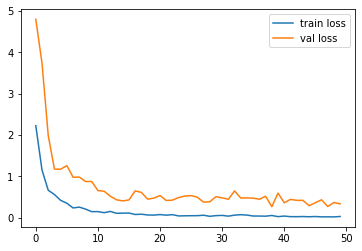

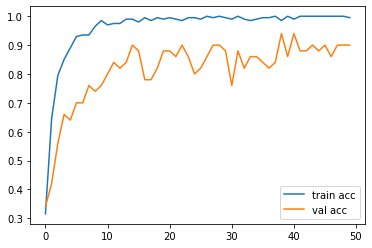

In [20]:
# plot the loss
# plot กราฟของค่า loss
plt.plot(history_densenet169.history['loss'], label='train loss')
plt.plot(history_densenet169.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
# plot กราฟของค่า accuracy
plt.plot(history_densenet169.history['accuracy'], label='train acc')
plt.plot(history_densenet169.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

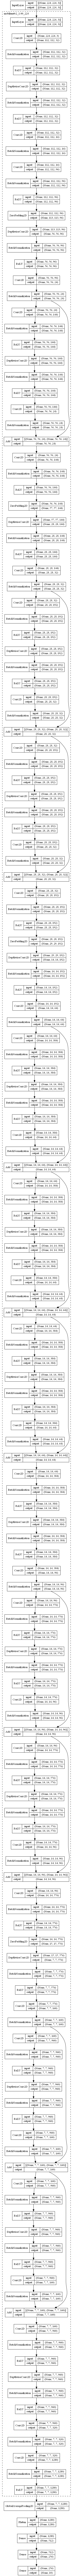

In [21]:
# ภาพการทำงานแต่ละ layers ของ MobileNetV2
plot_model(model_mobilenetv2, expand_nested=True, show_shapes=True, show_layer_names=False)

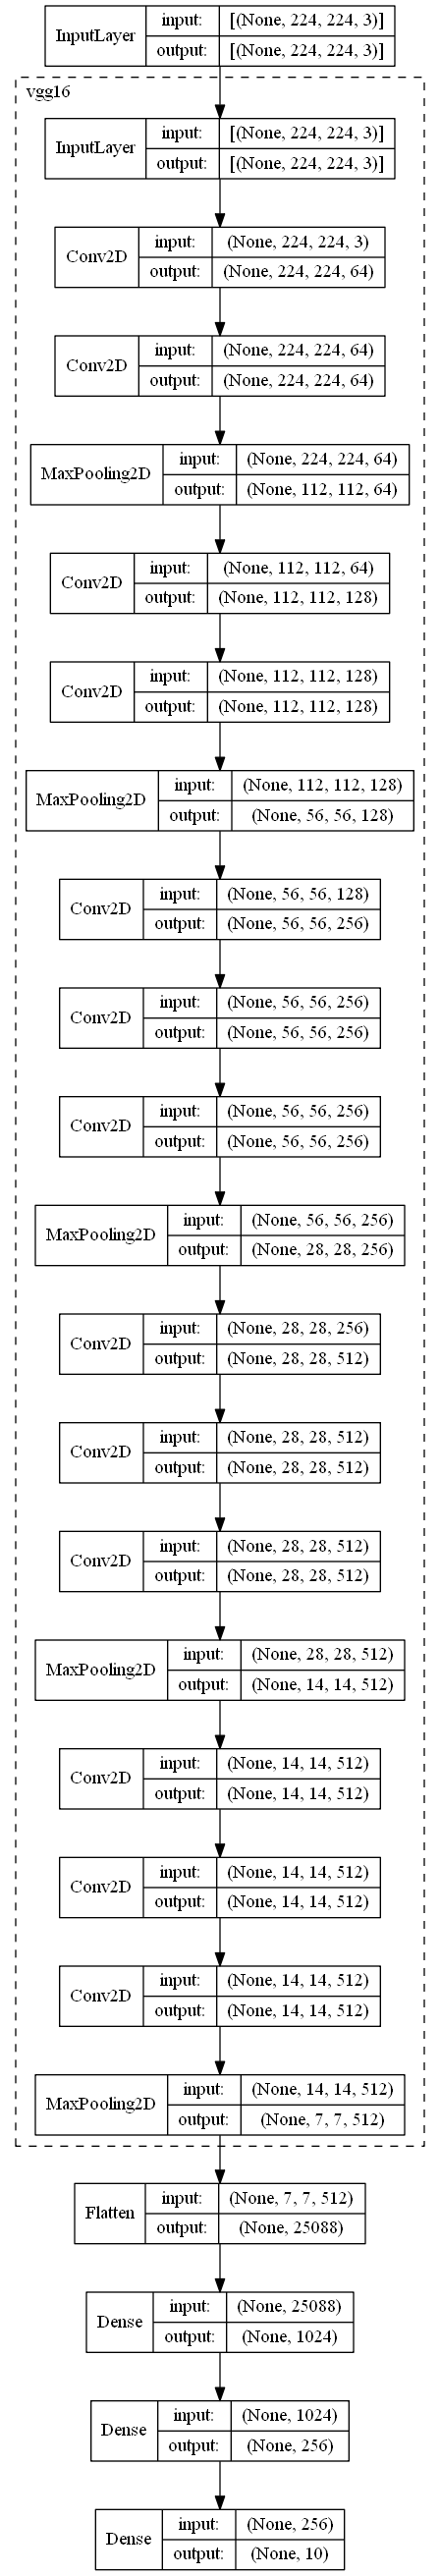

In [22]:
# ภาพการทำงานแต่ละ layers ของ VGG16
plot_model(model_vgg16, expand_nested=True, show_shapes=True, show_layer_names=False)

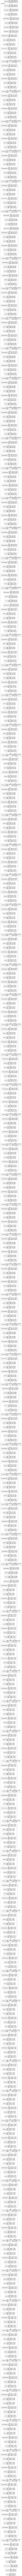

In [23]:
# ภาพการทำงานแต่ละ layers ของ DenseNet169
plot_model(model_densenet169, expand_nested=True, show_shapes=True, show_layer_names=False)

In [24]:
# import ชุดข้อมูล test ที่เตรียมไว้เข้ามา
test_img_paths = pd.read_csv('test_img_paths.csv')

In [25]:
# ปรับ scale ให้อยู่ใน range 0-1
test_datagen = ImageDataGenerator(rescale = 1./255)

In [26]:
test_set = test_datagen.flow_from_directory('Test_images',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            classes=classes_wo_digits)

Found 50 images belonging to 10 classes.


In [27]:
# ประเมินความถูกต้องของ VGG16 ของ test set

score = model_vgg16.evaluate(test_set)
print(score)

2/2 [==============================] - 5s 1s/step - loss: 0.9820 - accuracy: 0.6800
[0.9819892644882202, 0.6800000071525574]


In [28]:
# ประเมินความถูกต้องของ MobileNetV2 ของ test set
score = model_mobilenetv2.evaluate(test_set)
print(score)

2/2 [==============================] - 1s 374ms/step - loss: 0.6283 - accuracy: 0.7600
[0.6282938718795776, 0.7599999904632568]


In [29]:
# ประเมินความถูกต้องของ DenseNet169 ของ test set
score = model_densenet169.evaluate(test_set)
print(score)

2/2 [==============================] - 4s 1s/step - loss: 0.9271 - accuracy: 0.7200
[0.9270524382591248, 0.7200000286102295]


In [30]:
# function สำหรับการนำรูปภาพเข้ามาทดสอบ

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

def manual_testing(path):
    
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    
    prob_vgg16 = model_vgg16.predict(image)
    prob_mobilenetv2 = model_mobilenetv2.predict(image)
    prob_densenet169 = model_densenet169.predict(image)
    
    
    pred_vgg16 = np.argmax(prob_vgg16, axis = 1)
    pred_mobilenetv2 = np.argmax(prob_mobilenetv2, axis = 1)
    pred_densenet169 = np.argmax(prob_densenet169, axis = 1)


    return print("\nVGG16 Prediction: {} \nMobileNetV2 Prediction: {} \nDenseNet169 Prediction: {} "
                 .format(pred_vgg16, pred_mobilenetv2, pred_densenet169))

def plot(path):
    image = cv2.imread(path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
path = str(input())
manual_testing(path)
plot(path)